In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
from locustvr_converter import preprocess_matrex_data

##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file

In [2]:
#https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [2]:
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
colormap_name = "coolwarm"

Session 0.1: Load analysis methods in python dictionary form

In [221]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    

#Put the folder of your Unity experiment below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#parameter name means independent variable in the experiment
#parameter_name='kappa' 
parameter_name='mu'
#parameter_name='agent_speed'

Session 2.1: select animal based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [220]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",parameter_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",parameter_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values

    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [9]:
def trajectory_analysis(df_XY):
    trajec_lim=150
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(18, 14), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    #plt.rcParams['font.family'] = 'Helvetica'
    cmap = plt.get_cmap('viridis')
    ax1, ax2, ax3, ax4 = axes.flatten()
    ax1.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='ISI'
    )
    ax2.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 0'
    )
    ax3.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 45'
    )
    ax4.set(
        xlim=(-1*trajec_lim, trajec_lim),
        ylim=(-1*trajec_lim, trajec_lim),
        yticks=([-1*trajec_lim, 0, trajec_lim]),
        xticks=([-1*trajec_lim, 0, trajec_lim]),
        aspect=('equal'),
        title='Direction 315'
    )      
    for key, grp in df_XY.groupby('fname'):
        if grp['object_type'][0]=='empty_trial':
            ax1.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
        else:
            if grp['mu'][0]==0:
                ax2.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            elif grp['mu'][0]==45:
                ax3.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            elif grp['mu'][0]==315:
                ax4.scatter(grp["X"].values,grp["Y"].values, c=np.arange(grp.shape[0]), marker=".", alpha=0.5)
            else:
                print("unexpected direction")
    ax2.plot(df_agent.loc[df_agent['mu'] == 0]['X'].values,df_agent.loc[df_agent['mu'] == 0]['Y'].values,color='k')
    ax3.plot(df_agent.loc[df_agent['mu'] == 45]['X'].values,df_agent.loc[df_agent['mu'] == 45]['Y'].values,color='k')
    ax4.plot(df_agent.loc[df_agent['mu'] == 315]['X'].values,df_agent.loc[df_agent['mu'] == 315]['Y'].values,color='k')

    #plt.savefig(fig_name)
    plt.show()

In [7]:
def cal_speed(dif_x,dif_y,ts,number_frame_scene_changing=5):
    focal_distance_fbf=np.sqrt(np.sum([dif_x**2,dif_y**2],axis=0))
    focal_distance_fbf[0:number_frame_scene_changing]=np.nan
    instant_speed=focal_distance_fbf/np.diff(ts)
    return instant_speed

In [8]:
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")
analysis_window=[-55,55]

## Section 1.0, analysis walking behavours before and after the presence of stimulus

In [ ]:
trajec_lim=150
duration_for_baseline=3
alignment_with_stim_onset=0
number_frame_scene_changing=5
dif_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    if found_result is not None:
        df_agent = pd.read_hdf(found_result)
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), xy_pattern)
    if found_result is None:
        continue
    df_XY = pd.read_hdf(found_result)
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    #trajectory_analysis(df_XY)
    dif_across_trials=[]
    if 'basedline_v' in locals():
        del basedline_v
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
        distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
        ts=grp["ts"].to_numpy()
        dif_x=np.diff(focal_xy[0])
        dif_y=np.diff(focal_xy[1])
        instant_speed=cal_speed(dif_x,dif_y,ts)
        angles = np.degrees(np.arctan2(dif_y, dif_x)) ## return angles in degree, between -180 and 180
        angles[0:number_frame_scene_changing]=np.nan
        angular_speed=angles/np.diff(ts)
        #time_series_plot(distance_from_centre,instant_speed,angular_speed,frame_range)
        if 'object_type' in df.columns:
            if alignment_with_stim_onset:
                if grp['object_type'][0]=='emptytrial':
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                else:
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
            else:
                if grp['object_type'][0]=='emptytrial':
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
        else:
            if alignment_with_stim_onset:
                if grp['density'][0]==0.0:
                    print('ISI now')
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]

                else:
                    print('Stim now')
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
            else:
                if grp['density'][0]==0.0:
                    frame_range=analysis_window[1]*monitor_fps
                    d_of_interest=distance_from_centre[:frame_range]
                    v_of_interest=instant_speed[:frame_range]
                    w_of_interest=angular_speed[:frame_range]
                    if 'basedline_v' in locals():
                    #if trial_id%96 != 0 and 'basedline_v' in locals():
                        normalised_v=v_of_interest/basedline_v
                    else:
                        normalised_v=np.repeat(np.nan,v_of_interest.shape[0])
                else:
                    frame_range=analysis_window[0]*monitor_fps
                    d_of_interest=distance_from_centre[frame_range:]
                    v_of_interest=instant_speed[frame_range:]
                    w_of_interest=angular_speed[frame_range:]
                    basedline_v=np.mean(v_of_interest[-duration_for_baseline*monitor_fps:])
                    normalised_v=np.repeat(np.nan,v_of_interest.shape[0])

        if 'object_type' in df.columns:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['object_type'][0],v_of_interest.shape[0]))
        else:
            con_matrex=(d_of_interest,v_of_interest,w_of_interest,normalised_v,np.repeat(trial_id,v_of_interest.shape[0]),np.repeat(grp['mu'][0],v_of_interest.shape[0]),np.repeat(grp['density'][0],v_of_interest.shape[0]))
        raw_data=np.vstack(con_matrex)
        dif_across_trials.append(pd.DataFrame(np.transpose(raw_data)))
        trial_id += 1
    tmp=pd.concat(dif_across_trials)
    if 'object_type' in df.columns:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','id','mu','object']
    else:
        tmp.columns = ['distance_from_centre', 'velocity','omega','normalised_v','id','mu','density']
    tmp.insert(0, 'animal_id', np.repeat(animal_id,tmp.shape[0]))
    dif_across_animals.append(tmp)
    animal_id += 1

In [15]:
all_trials=pd.concat(dif_across_animals)
all_trials['id'] = all_trials['id'].astype(int)
all_trials['mu'] = all_trials['mu'].astype(int)
all_trials['density'] = all_trials['density'].astype(int)

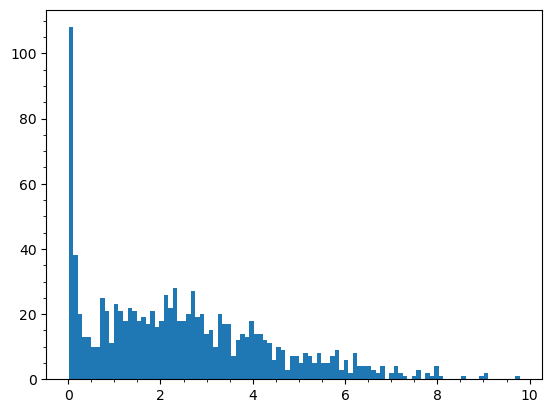

In [16]:
these_baselines=[]
for keys, this_data in all_trials.groupby(['animal_id','id']):
    if keys[1]%2!=0:#to only use stim trials
        this_speed=this_data['velocity'].values
        these_baselines.append(np.mean(this_speed[-duration_for_baseline*monitor_fps:]))
plt.hist(np.vstack(these_baselines),bins=100)
plt.minorticks_on()
plt.show()

In [31]:
walk_threshold=3
walk_trials_boo=[]
these_speed=[]
these_normalised_speed=[]
for keys, this_data in all_trials.groupby(['animal_id','id']):
    this_speed=this_data['velocity'].values
    baseline_speed=np.mean(this_speed[-duration_for_baseline*monitor_fps:])
    walk_trials_boo.append(baseline_speed>walk_threshold)
    these_speed.append(this_speed)
    these_normalised_speed.append(this_data['normalised_v'].values)

In [32]:
after_walk_ith_trial=[]
after_walk_ith_trial=[i+1 for i, x in enumerate(walk_trials_boo[1::2]) if x and i % int((trial_id)/2) != (trial_id)/2-1]
if walk_trials_boo[1]==True:
    after_walk_ith_trial.insert(1)

In [33]:
tmp=np.vstack(these_speed)
isi_speed=tmp[::2]
tmp=np.vstack(these_normalised_speed)
isi_norm_speed=tmp[::2]

In [93]:
monitor_fps=analysis_methods.get('monitor_fps')
prefered_fps=monitor_fps/2
x = np.linspace(0, isi_speed.shape[1]/monitor_fps, num=isi_speed.shape[1])
bin_mean_speed, bin_edges, binnumber = stats.binned_statistic(x, isi_speed[after_walk_ith_trial,:],
        statistic='mean', bins=prefered_fps)

In [94]:
bin_mean_normalised_speed, bin_edges, binnumber = stats.binned_statistic(x, isi_norm_speed[after_walk_ith_trial,:],
        statistic='mean', bins=prefered_fps)

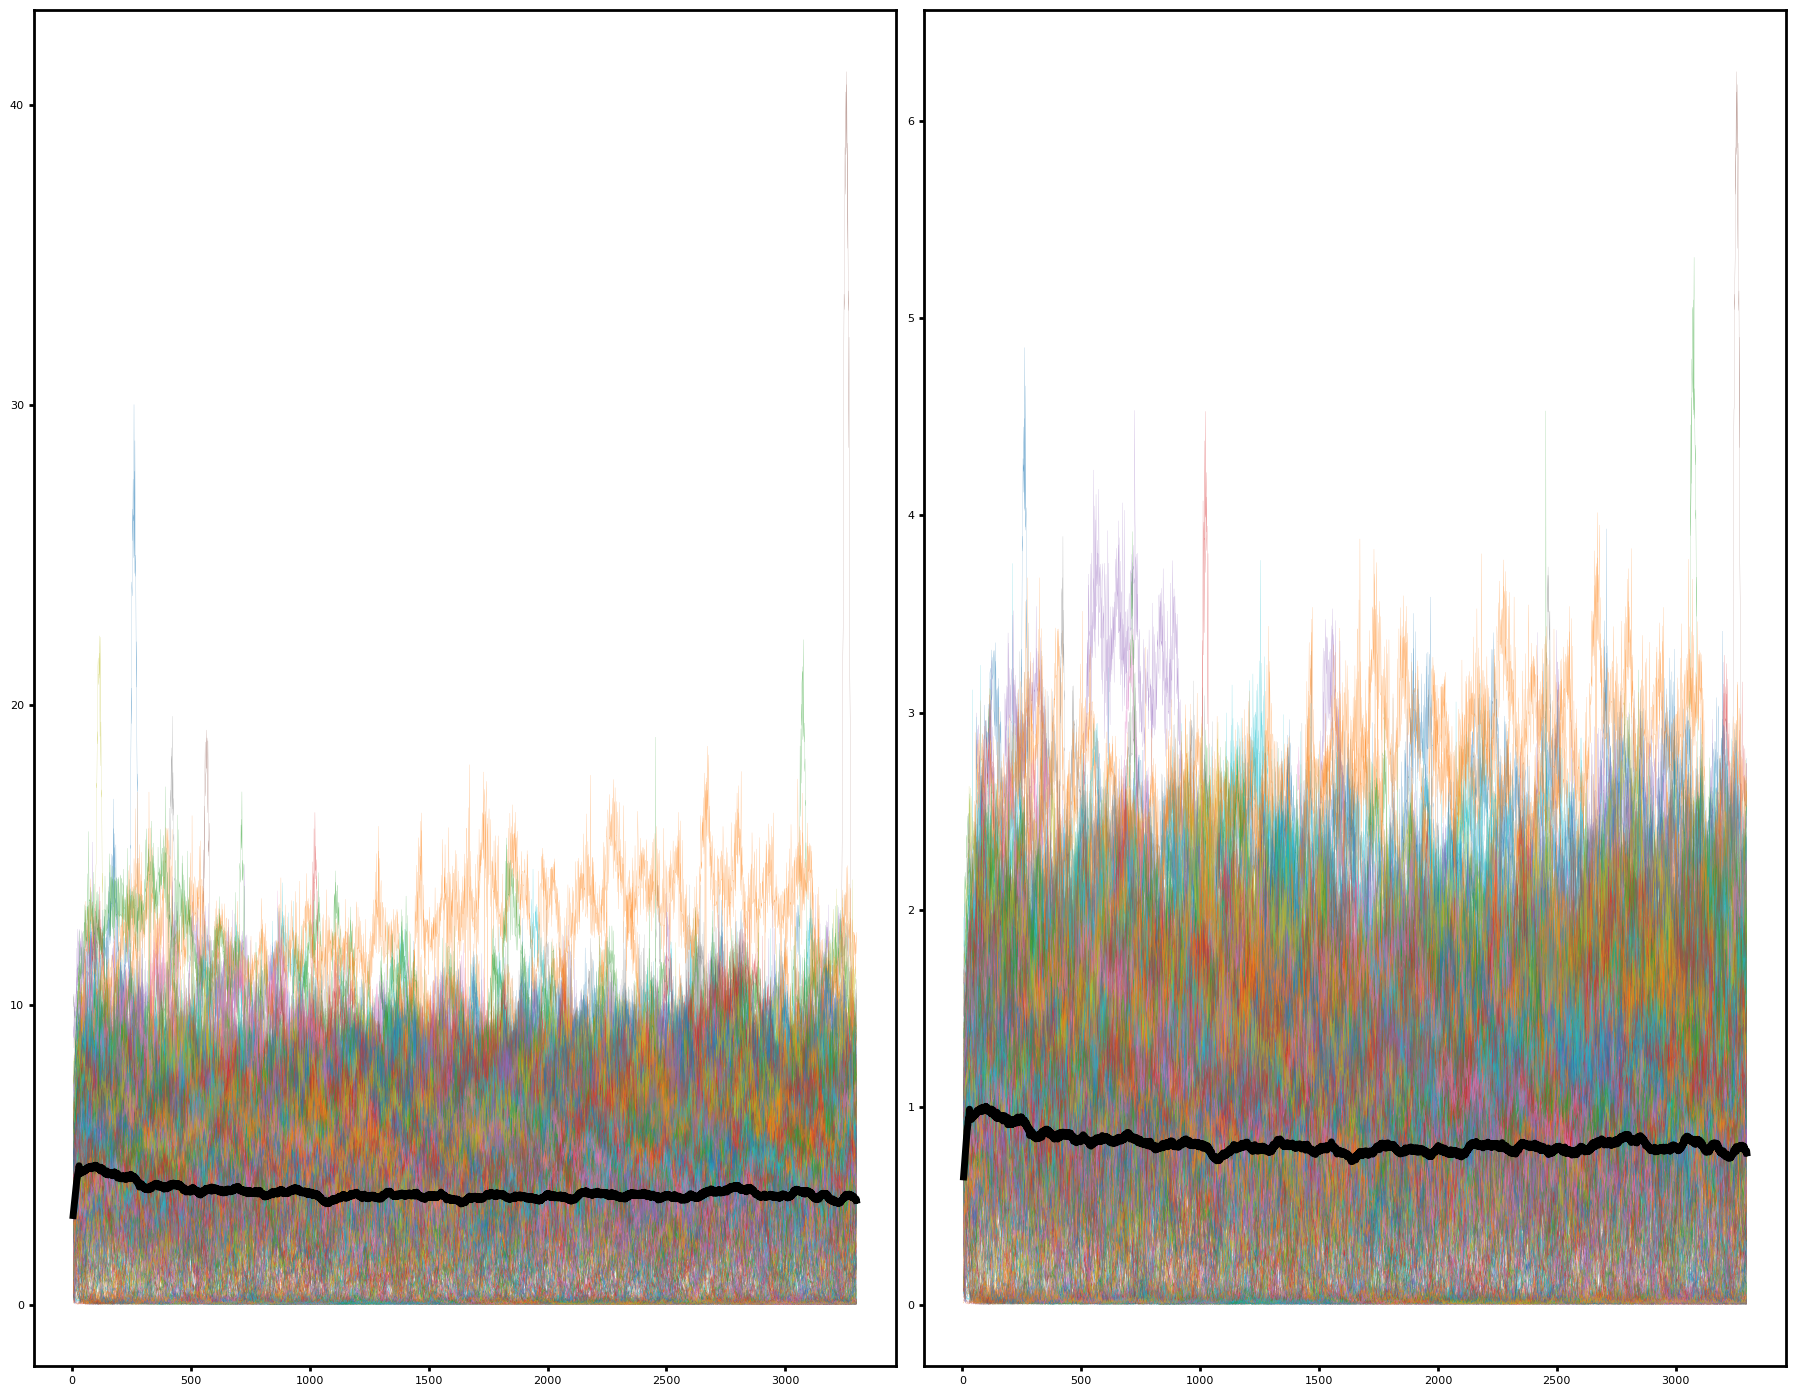

In [132]:
fig, (ax1,ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(18, 14), tight_layout=True
    )
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 8})
# Set the axis line width to 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2
cmap = plt.get_cmap('viridis')
# ax1.set(
#     # yticks=[0,90,180],
#     #ylim=(-np.pi-0.1, np.pi+0.1),
#     ylim=(0, 10),
# )

#ax1.plot(bin_edges[:-1],np.transpose(bin_mean_speed),linewidth=0.1)
#ax1.scatter(np.tile(bin_edges[:-1],(bin_mean_speed.shape[0],1)),bin_mean_speed)
# for i in range(bin_mean_speed.shape[0]):
#     ax1.hlines(bin_mean_speed[i,:], bin_edges[:-1], bin_edges[1:],lw=2)
# #ax2.plot(bin_edges[:-1],np.transpose(bin_mean_normalised_speed),linewidth=0.1)
ax1.plot(np.transpose(isi_speed[after_walk_ith_trial,:]),linewidth=0.1)
ax1.plot(np.mean(isi_speed[after_walk_ith_trial,:],axis=0),'k',linewidth=5)
ax2.plot(np.transpose(isi_norm_speed[after_walk_ith_trial,:]),linewidth=0.1)

ax2.plot(np.mean(isi_norm_speed[after_walk_ith_trial,:],axis=0),'k',linewidth=5)
plt.show()

## Section 1.1, analysis following behavours in response to receding stimuli from different direction.

In [146]:
def time_series_plot(target_distance,instant_speed,angles,analysis_window):
    fig, axes = plt.subplots(
        nrows=3, ncols=1, figsize=(9, 7), tight_layout=True
    )
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    cmap = plt.get_cmap('viridis')
    ax1, ax2, ax3= axes.flatten()
    ax1.set(
        title='Distance'
    )
    ax2.set(
        title='Instant Speed'
    )
    ax3.set(
        # yticks=[0,90,180],
        #ylim=(-np.pi-0.1, np.pi+0.1),
        # ylim=(-5, 185),
        title='angular deviation'
    )
    # ax3.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    # ax3.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
    # ax3.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax1.plot(np.arange(target_distance.shape[0]),target_distance)
    ax2.plot(np.arange(instant_speed.shape[0]),instant_speed)
    ax3.plot(np.arange(angles.shape[0]),angles)
    plt.show()

In [222]:
trajec_lim=150
max_target_distance=50
number_frame_scene_changing=5
dif_across_animals=[]
raw_across_animals=[]
follow_proportion_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        print(f'no such a dir exist {this_dir}')
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), agent_pattern)
    df_agent = pd.read_hdf(found_result)
    found_result = find_file(Path(this_dir), xy_pattern)
    df_XY = pd.read_hdf(found_result)
    df_agent['this_vr']=this_vr
    df_agent['fname']=df_agent['fname'].astype(str) + '_' + df_agent['this_vr'].astype(str)   
    df_XY['this_vr']=this_vr
    df_XY['fname']=df_XY['fname'].astype(str) + '_' + df_XY['this_vr'].astype(str)
    #trajectory_analysis(df_XY)
    dif_across_trials=[]
    follow_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    total_epochs_across_trials=np.ones((len(df_agent['fname'].unique()),1))
    raw_data_list=[]
    trial_id=0
    for key, grp in df_XY.groupby('fname'):
        if grp['object_type'][0]=='empty_trial':
            continue
        else:
            #print(f"stimulus degree: {grp['mu'][0]}")
            focal_xy=np.vstack((grp["X"].to_numpy(),grp["Y"].to_numpy()))
            distance_from_centre=np.sqrt(np.sum([focal_xy[0]**2,focal_xy[1]**2],axis=0))
            ts=grp["ts"].to_numpy()
            instant_speed= cal_speed(np.diff(focal_xy[0]),np.diff(focal_xy[1]),ts)
            focal_distance_fbf=instant_speed*np.diff(ts)
            agent_xy=np.vstack((df_agent[df_agent['fname']==key]["X"].to_numpy(),df_agent[df_agent['fname']==key]["Y"].to_numpy()))
            agent_distance_fbf=np.sqrt(np.sum([np.diff(agent_xy)[0]**2,np.diff(agent_xy)[1]**2],axis=0))
            vector_dif=agent_xy-focal_xy
            theta = np.radians(grp['mu'][0]-360)  
            rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])# calculate the rotation matrix to align the agent to move along the same direction
            vector_dif_rotated=rot_matrix @ vector_dif
            target_distance=LA.norm(vector_dif, axis=0)
            dot_product=np.diag(np.matmul(np.transpose(np.diff(focal_xy)),np.diff(agent_xy)))
            angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
            angles_in_degree= angles*180/np.pi
            #time_series_plot(target_distance,instant_speed,angles_in_degree,analysis_window)
            trial_of_interest=np.logical_and(target_distance[1:]<max_target_distance, instant_speed>1)
            follow_sercan=np.logical_and(target_distance[1:]<max_target_distance, instant_speed>1,angles_in_degree<10)

            vector_dif_rotated=vector_dif_rotated[:,1:]
            degree_in_the_trial=np.repeat(grp['mu'][0],np.transpose(grp['ts'].values).shape[0])
            degree_time=np.vstack((degree_in_the_trial,grp['ts'].values))
            degree_time=degree_time[:,1:]
            follow_wrap=np.concat((vector_dif_rotated[:,trial_of_interest],degree_time[:,trial_of_interest]))
            dif_across_trials.append(pd.DataFrame(np.transpose(follow_wrap)))
            ###wrap up some raw data
            follow_epochs_across_trials[trial_id]=sum(follow_sercan)
            total_epochs_across_trials[trial_id]=angles_in_degree.shape[0]
            id_time=np.vstack((np.repeat(trial_id,np.transpose(grp['ts'].values).shape[0]),grp['ts'].values))
            con_matrex=(focal_xy,agent_xy,id_time)
            raw_data=np.concat(con_matrex)
            raw_data_list.append(pd.DataFrame(np.transpose(raw_data)))
            trial_id=trial_id+1
    tmp=pd.concat(dif_across_trials)
    if tmp.shape[1]==2:
        tmp.columns = ['x', 'y']
    elif tmp.shape[1]==4:
        tmp.columns = ['x', 'y','degree','ts']
    r_tmp=pd.concat(raw_data_list)
    r_tmp.columns=['focal_x','focal_y','agent_x','agent_y','trial_id','ts']
    r_tmp.insert(0, 'animal_id', np.repeat(animal_id,r_tmp.shape[0]))
    #fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    #plt.hist2d(tmp['x'].values,tmp['y'].values)
    #fig, ax = plt.subplots(dpi=300, figsize=(2,2))
    #sns.histplot(tmp,x='x',y='y')
    #plt.show()
    follow_proportion_across_animals.append(sum(follow_epochs_across_trials)[0]/sum(total_epochs_across_trials)[0])
    dif_across_animals.append(tmp)
    raw_across_animals.append(r_tmp)
    animal_id=animal_id+1

for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_143943
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_143943
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_143943
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_163554
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_163554
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_184143
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_184143
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240824_184143
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_132616
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_151648
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_151648
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_170748
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_170748
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20240825_170748
for such a dir exist D:/MatrexVR_g

C:\Users\neuroPC\AppData\Local\Temp\ipykernel_21200\2802888774.py:47: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
C:\Users\neuroPC\AppData\Local\Temp\ipykernel_21200\2802888774.py:47: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
C:\Users\neuroPC\AppData\Local\Temp\ipykernel_21200\2802888774.py:47: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
C:\Users\neuroPC\AppData\Local\Temp\ipykernel_21200\2802888774.py:47: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
C:\Users\neuroPC\AppData\Local\Temp\ipykernel_21200\2802888774.py:47: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dot_product/focal_distance_fbf/agent_distance_fbf)
C:\Users\neuroPC\AppData\Local

for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_162147
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_162147
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_162147
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_162147
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_182305
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_182305
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_182305
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_201706
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_201706
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241012_201706
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241013_144457
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241013_144457
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241013_144457
for such a dir exist D:/MatrexVR_grass1_Data/RunData/20241013_164304
for such a dir exist D:/MatrexVR_g

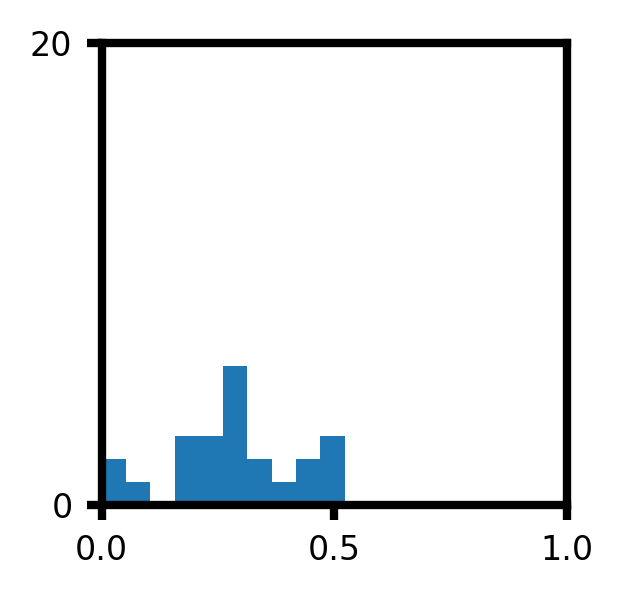

In [223]:
fig, ax = plt.subplots(dpi=300, figsize=(2,2))
ax.hist(np.vstack(follow_proportion_across_animals))
#ax1.set(adjustable='box', aspect='equal')
ax.set(xticks=[0,0.5,1],xlim=(0,1),yticks=[0,20],ylim=(0,20))
plt.show()

stimulus degree: 0.0
stimulus degree: 45.0
stimulus degree: 315.0


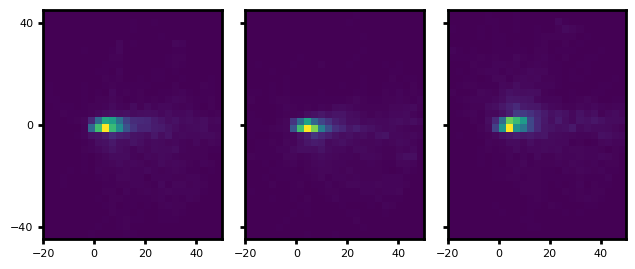

In [224]:
all_trials=pd.concat(dif_across_animals)
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials["degree"].unique()),tight_layout=True,sharex=True, sharey=True)
i=0
for key, grp in all_trials.groupby('degree'):
    print(f"stimulus degree: {key}")
    axes[i].hist2d(grp['x'].values,grp['y'].values,bins=36)
    axes[i].set(adjustable='box', aspect='equal')
    axes[i].set(
    yticks=[-40,0,40],
    xticks=[-20,0,20,40],
    xlim=(-20,50),ylim=(-45, 45))
    i=i+1
plt.show()

In [ ]:
##plot potential follow response in 2D histogram
all_trials=pd.concat(dif_across_animals)
fig, ax = plt.subplots(dpi=300, figsize=(2,2))
plt.hist2d(all_trials['x'].values,all_trials['y'].values,bins=36)
fig, ax = plt.subplots(dpi=300, figsize=(2,2))
sns.histplot(all_trials,x='x',y='y')
plt.show()

In [ ]:
#some criteria for follow
angles_in_degree<10
instant_speed>1
follow_response=np.logical_and(angles_in_degree<10, instant_speed>1)
print(follow_response)

In [ ]:
##save the raw data into mat file for matlab
from scipy.io import savemat
all_raw=pd.concat(raw_across_animals)
all_raw['trial_id']=all_raw['trial_id'].astype(int)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)